In [87]:
import gzip
import numpy as np
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt

from bigdl.util.common import *
from bigdl.nn.layer import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.nn.layer import *

import tensorflow as tf
import matplotlib.pyplot as plt1
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.callbacks import Callback

import datetime as dt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns

from pyspark import SparkContext


In [88]:
# Get the spark context
sc = SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[*]").set("spark.driver.memory","2g"))
init_engine()

In [89]:
def download_mnist(path, kind='train'):
    print("Downloading the Fashion Mnist {} dataset...".format(kind), end='')
    images_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/{}-images-idx3-ubyte.gz".format(kind)
    labels_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/{}-labels-idx1-ubyte.gz".format(kind)

    urllib.request.urlretrieve(images_url, os.path.join(path,"{}-images-idx3-ubyte.gz".format(kind)))
    urllib.request.urlretrieve(labels_url, os.path.join(path,"{}-labels-idx1-ubyte.gz".format(kind)))
    print("done.")

def load_mnist(path, kind='train'):

    labels_path = os.path.join(path,"{}-labels-idx1-ubyte.gz".format(kind) )
    images_path = os.path.join(path,"{}-images-idx3-ubyte.gz".format(kind) )

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return (images, labels)

In [90]:
path = "bigdl-data/fashion_mnist"
Path(path).mkdir(parents=True, exist_ok=True)
download_mnist(path)
download_mnist(path, kind='t10k')
train_images, train_labels = load_mnist(path)
test_images, test_labels = load_mnist(path, kind='t10k')

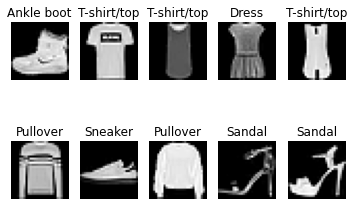

In [91]:
label_index = [ "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot" ]

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(np.column_stack(train_images[i].reshape(1, 28,28)),cmap="gray"); plt.axis("off")
    ax.set_title(label_index[train_labels[i]])


In [92]:
#Normalization
training_mean = np.mean(train_images)
training_std = np.std(train_images)
rdd_train_images = sc.parallelize(train_images)
rdd_train_labels = sc.parallelize(train_labels)
rdd_test_images = sc.parallelize(test_images)
rdd_test_labels = sc.parallelize(test_labels)

train_feats = np.array([(feat - training_mean) / training_std for feat in train_images])
rdd_train_sample = sc.parallelize([Sample.from_ndarray(feat, label+1) for feat, label in zip(train_feats, train_labels)])

test_feats = np.array([(feat - training_mean) / training_std for feat in test_images])
rdd_test_sample = sc.parallelize([Sample.from_ndarray(feat, label+1) for feat, label in zip(test_feats, test_labels)])

In [93]:
print("Number of training samples: {}".format(rdd_train_sample.count()))
print("Number of test samples: {}".format(rdd_test_sample.count()))

Number of training samples: 60000
Number of test samples: 10000


In [94]:
learning_rate = 0.4
training_epochs = 40
batch_size = 1024
display_step = 1

# Network Parameters
# 1st layer number of features
n_hidden_1 = 256 
# 2nd layer number of features
n_hidden_2 = 256
# MNIST data input (img shape: 28*28)
n_input = 784
# MNIST total classes (0-9 digits)
n_classes = 10 

In [95]:
from bigdl.nn.layer import *
model = Sequential() 
model.add(Reshape([1, 28, 28]))
model.add(SpatialConvolution(1, 6, 5, 5).set_name('conv1'))

model.add(Tanh())

model.add(SpatialAveragePooling(2, 2, 2, 2).set_name('pool1'))

#model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool1'))
model.add(Tanh())

model.add(SpatialConvolution(6, 12, 5, 5).set_name('conv2'))

model.add(SpatialAveragePooling(2, 2, 2, 2).set_name('pool2'))
#model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool2'))

model.add(Reshape([12 * 4 * 4]))
model.add(Linear(12 * 4 * 4, 100).set_name('fc1'))
model.add(Tanh())

model.add(Linear(100, 10).set_name('score'))
model.add(LogSoftMax())
print(model)

creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createTanh
creating: createSpatialAveragePooling
creating: createTanh
creating: createSpatialConvolution
creating: createSpatialAveragePooling
creating: createReshape
creating: createLinear
creating: createTanh
creating: createLinear
creating: createLogSoftMax
Sequential[f1a396ec]{
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> output]
  (1): Reshape[de671b0e](1x28x28)
  (2): SpatialConvolution[conv1](1 -> 6, 5 x 5, 1, 1, 0, 0)
  (3): Tanh[e594da01]
  (4): SpatialAveragePooling[pool1](2, 2, 2, 2, 0, 0)
  (5): Tanh[1cdc6b2a]
  (6): SpatialConvolution[conv2](6 -> 12, 5 x 5, 1, 1, 0, 0)
  (7): SpatialAveragePooling[pool2](2, 2, 2, 2, 0, 0)
  (8): Reshape[26e43a3f](192)
  (9): Linear[fc1](192 -> 100)
  (10): Tanh[26e037d9]
  (11): Linear[score](100 -> 10)
  (12): LogSoftMax[b477e148]
}


In [96]:
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
import datetime as dt

# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=rdd_train_sample,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=learning_rate),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=rdd_test_sample,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy(),Loss()]
)

app_name='CNN_with_Lenet5_arch-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(40))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
##t= "10"
##optimizer.set_checkpoint('/checkpoints',t,isOverWrite=True)

print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createClassNLLCriterion
creating: createLoss
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  CNN_with_Lenet5_arch-20220515-160016


/home/sunil3/miniconda3/envs/review1/lib/python3.6/site-packages/bigdl/optim/optimizer.py:864: UserWarning: You are recommended to use `create` method to create an optimizer.
  warnings.warn("You are recommended to use `create` method to create an optimizer.")


In [97]:
%%time
optimizer.optimize();

CPU times: user 53.3 ms, sys: 5.98 ms, total: 59.3 ms
Wall time: 7min 28s


In [115]:
#in seconds
Wall_Time_B=448

In [99]:
loss_val2 = np.array(train_summary.read_scalar("Accuracy"))
loss_val = np.array(val_summary.read_scalar("Loss"))

print(len(loss_val2))

0


In [ ]:
acc_training = np.array(val_summary.read_scalar("Top1Accuracy"))

In [119]:
print((acc_t[:,1]))

[0.68440002 0.7687     0.77509999 0.77630001 0.83469999 0.83399999
 0.83890003 0.84539998 0.85039997 0.8434     0.85970002 0.86089998
 0.86210001 0.84979999 0.85949999 0.8664     0.8725     0.86809999
 0.87129998 0.8739     0.86650002 0.87989998 0.87739998 0.87840003
 0.87410003 0.87949997 0.88230002 0.88270003 0.88480002 0.88480002
 0.86470002 0.88590002 0.86699998 0.88510001 0.88520002 0.88749999
 0.88550001 0.88620001 0.88859999 0.8865    ]


Text(0.5, 1.0, 'Loss with spark')

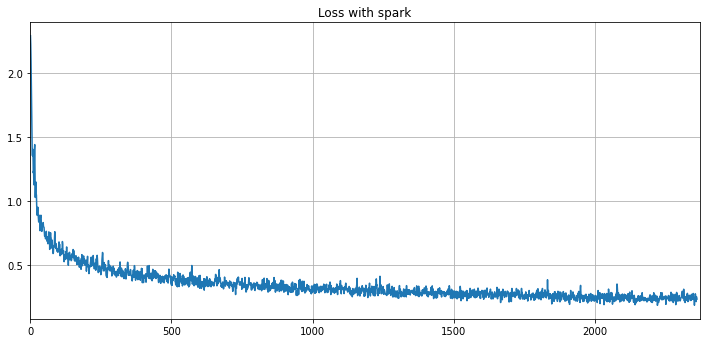

In [101]:
import matplotlib.pyplot as plt
loss_train = np.array(train_summary.read_scalar("Loss"))
acc_t = np.array(val_summary.read_scalar("Top1Accuracy"))

#loss = np.array(train_summary.read_scalar("Loss"))
#oss_train = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss_train[:,0],loss_train[:,1],label='loss')
plt.xlim(0,loss_train.shape[0]+10)
plt.grid(True)
plt.title("Loss with spark")

Text(0.5, 1.0, 'Accuracy with spark')

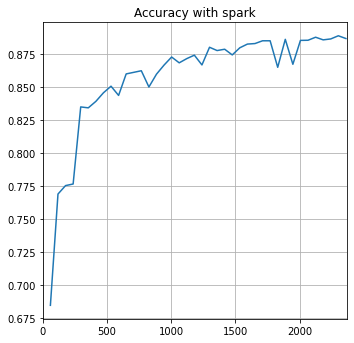

In [102]:
plt.figure(figsize = (12,12))
plt.subplot(2,2,2)
plt.plot(acc_t[:,0],acc_t[:,1],label='loss')
plt.xlim(0,loss_train.shape[0]+10)
plt.grid(True)
plt.title("Accuracy with spark")

In [103]:
accuracy_test =np.array(val_summary.read_scalar("Top1Accuracy"))
print(len(accuracy_test))

40


The prediction accuracy is 88.67%


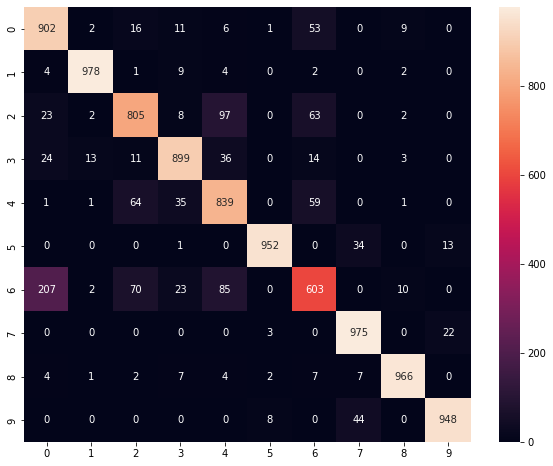

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns

#Labels are 1-indexed in BigDL:
y_pred = np.array(model.predict_class(rdd_test_sample).collect())-1
y_label = np.array([s.label.to_ndarray()[0] - 1 for s in rdd_test_sample.collect()])

acc = accuracy_score(y_label, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_label, y_pred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True,fmt='d');

In [105]:
#Implementaion of the same model with same dataset without Spark

In [106]:
(x_train,y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()
x_train.shape
#Normalization
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train.shape

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train.shape

x_val = x_train[-2000:,:,:,:] 
y_val = y_train[-2000:] 
x_train = x_train[:-2000,:,:,:] 
y_train = y_train[:-2000]

In [107]:
model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=x_train.shape[1:]))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(16, 5, activation='tanh'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(120, 5, activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
activation_3 (Activation)    (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 120)        

In [108]:
opt = tf.keras.optimizers.SGD(learning_rate= 0.4)

In [109]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy1 = []
       
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy1.append(logs.get('accuracy'))
        
loss_history = LossHistory()
model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])


In [110]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=40,
                    verbose=2,
                    validation_data=(x_val, y_val),
                    callbacks=[loss_history])

Epoch 1/40
57/57 - 17s - loss: 2.5715 - accuracy: 0.0999 - val_loss: 2.3291 - val_accuracy: 0.0930
Epoch 2/40
57/57 - 16s - loss: 2.3157 - accuracy: 0.0977 - val_loss: 2.3169 - val_accuracy: 0.1065
Epoch 3/40
57/57 - 15s - loss: 2.3093 - accuracy: 0.1012 - val_loss: 2.3071 - val_accuracy: 0.1035
Epoch 4/40
57/57 - 13s - loss: 2.3063 - accuracy: 0.1061 - val_loss: 2.3099 - val_accuracy: 0.1100
Epoch 5/40
57/57 - 16s - loss: 2.2804 - accuracy: 0.1369 - val_loss: 2.2100 - val_accuracy: 0.1555
Epoch 6/40
57/57 - 15s - loss: 2.0945 - accuracy: 0.2312 - val_loss: 1.4750 - val_accuracy: 0.4290
Epoch 7/40
57/57 - 16s - loss: 1.4424 - accuracy: 0.4458 - val_loss: 1.2301 - val_accuracy: 0.5415
Epoch 8/40
57/57 - 15s - loss: 1.2130 - accuracy: 0.5189 - val_loss: 1.3022 - val_accuracy: 0.4920
Epoch 9/40
57/57 - 16s - loss: 1.0674 - accuracy: 0.5701 - val_loss: 0.9158 - val_accuracy: 0.6020
Epoch 10/40
57/57 - 14s - loss: 1.2895 - accuracy: 0.5379 - val_loss: 0.9546 - val_accuracy: 0.6020
Epoch 11/

In [120]:
Wall_Time_K = 590

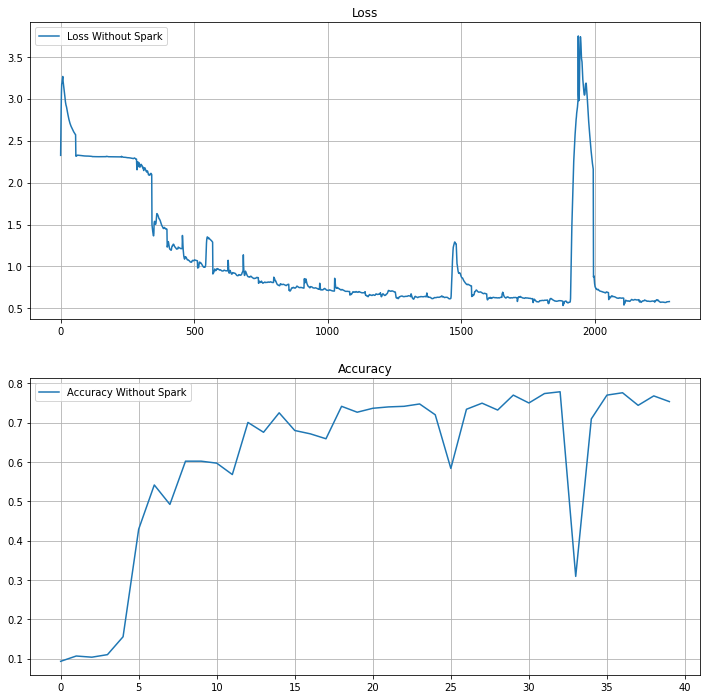

In [112]:

import matplotlib.pyplot as plt1
validation_data=(x_val, y_val)
fig, axs = plt1.subplots(2, 1, figsize=(12,12))
plt1.grid(True)
axs[0].grid(True)
axs[0].plot(loss_history.losses) 

axs[0].title.set_text('Loss')
axs[0].legend(['Loss Without Spark']) 
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Accuracy') 
axs[1].legend(['Accuracy Without Spark'])
#print(loss_history.val_loss1)

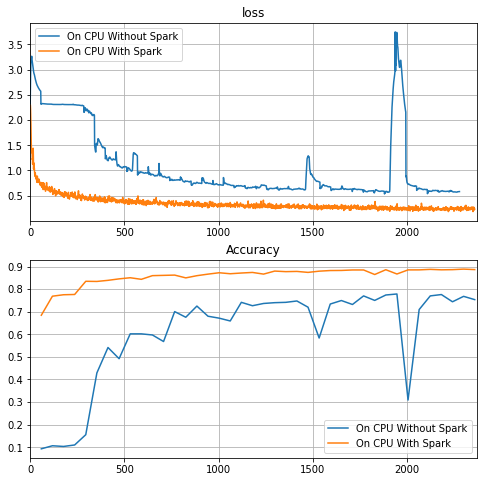

In [118]:
#Comparision of results from both mode of execution
import matplotlib.pyplot as plt
accuracy_test = np.array(train_summary.read_scalar("Top1Accuracy"))
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)

plt.plot(loss_history.losses) 
plt.plot(loss_train[:,0],loss_train[:,1],label='loss')
plt.xlim(0,loss_train.shape[0]+10)
plt.legend(['On CPU Without Spark', 'On CPU With Spark'])
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(acc_t[:,0],history.history['val_accuracy'])
#plt.plot(acc_t[:,0],acc_t[:,0])
plt.plot(acc_t[:,0],acc_t[:,1],label='loss')
plt.xlim(0,loss_train.shape[0]+10)
plt.legend(['On CPU Without Spark', 'On CPU With Spark'])
plt.title("Accuracy")
plt.grid(True)

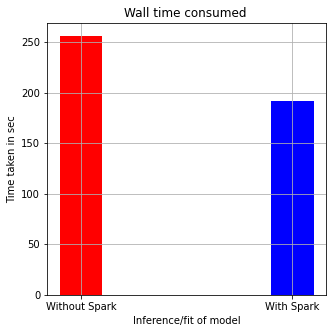

In [114]:
import matplotlib.pyplot as plt3
 
# creating the dataset
#data = {'Without Spark':263400, 'With Spark':234000, }

fig = plt.figure(figsize = (5, 5))
 

a =["Without Spark","With Spark"]     #  width = 0.1)
b =[Wall_Time_K,Wall_Time_B]
c =["Red","Blue"]
#bar plot
plt.bar(a,height = b, color = c,width = 0.2)
#plt.bar(b, height = 5, color = "Green")

 
plt.xlabel("Inference/fit of model")
plt.ylabel("Time taken in sec")
plt.title("Wall time consumed ")
plt.grid(True)
plt.show()

